In [1]:
from surprise.model_selection import train_test_split
from surprise import KNNBasic, accuracy
from surprise import Dataset, Reader
from surprise.dump import dump

from recmetrics import rmse, mse, mark, mark_plot

from os.path import join, split
from random import sample

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

from utils import *

In [2]:
_HERE = '' # split(__file__)[0]

# Read dataset

In [3]:
ratings = ratings_df()
ratings = ratings.query('rating >=3')
ratings = ratings.sample(n=1000)
ratings.reset_index(drop=True, inplace=True)

ratings.head()

,userId,movieId,rating
0,142600,648,3.0
1,7784,86347,4.0
2,103640,2324,5.0
3,39345,5219,4.0
4,81355,2966,3.0


# k-NN Model training

In [4]:
reader = Reader(rating_scale=(0, 5))
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader=reader)
trainset, testset = train_test_split(data, test_size=.25)

In [5]:
sim_options = {'name': 'cosine',
               'user_based': False  # compute  similarities between items
               }
algo = KNNBasic(k=2, sim_options=sim_options, verbose=True)

In [6]:
algo.fit(trainset)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [7]:
testset[0]

(76710, 1266, 5.0)

In [8]:
preds = algo.test(testset, verbose=False)

In [9]:
preds = pd.DataFrame(preds)
preds.drop("details", inplace=True, axis=1)
preds.columns = ['userId', 'movieId', 'actual', 'cf_predictions']
preds.head()

,userId,movieId,actual,cf_predictions
0,76710,1266,5.0,3.892
1,24856,1307,3.5,3.892
2,118803,3487,3.0,3.892
3,9633,1214,4.0,3.892
4,74045,17,4.0,3.892


# Recommendations

In [10]:
cf_model = preds.pivot_table(index='userId', columns='movieId', values='cf_predictions').fillna(0)
cf_model.head()

movieId,1,6,17,30,31,36,47,50,61,62,...,104841,109487,114180,132952,136556,139385,142115,144580,165551,201747
userId,,,,,,,,,,,,,,,,,,,,,
3472,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4254,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4458,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5016,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5335,3.892,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
test = preds.copy().groupby('userId', as_index=False)['movieId'].agg({'actual': (lambda x: list(set(x)))})
test = test.set_index("userId")
test.head()

,actual
userId,
3472,[4011]
4254,[349]
4458,[509]
5016,[54775]
5335,[1]


# k-NN recommendations

In [12]:
def get_users_predictions(user_id, n, model):
    recommended_items = pd.DataFrame(model.loc[user_id])
    recommended_items.columns = ["predicted_rating"]
    recommended_items = recommended_items.sort_values('predicted_rating', ascending=False)    
    recommended_items = recommended_items.head(n)
    return recommended_items.index.tolist()

In [13]:
# make recommendations for all members in the test data
cf_recs = [] = []
for user in tqdm(test.index, desc='k-NN recommendations', total=len(test.index)):
    cf_predictions = get_users_predictions(user, 10, cf_model)
    cf_recs.append(cf_predictions)
        
test['cf_predictions'] = cf_recs
test.head()

k-NN recommendations: 100%|██████████| 249/249 [00:00<00:00, 734.39it/s]


,actual,cf_predictions
userId,,
3472,[4011],"[4011, 1, 4027, 4262, 4292, 4809, 4901, 4993, ..."
4254,[349],"[349, 1, 4027, 4262, 4292, 4809, 4901, 4993, 5..."
4458,[509],"[509, 8361, 4103, 4262, 4292, 4809, 4901, 4993..."
5016,[54775],"[54775, 1, 5481, 4262, 4292, 4809, 4901, 4993,..."
5335,[1],"[1, 5574, 4262, 4292, 4809, 4901, 4993, 5064, ..."


# Popularity-based recommendations

In [14]:
#make recommendations for all members in the test data
popularity_recs = ratings.movieId.value_counts().head(10).index.tolist()

pop_recs = []
for user in tqdm(test.index, desc='Popularity-based recommendations', total=len(test.index)):
    pop_predictions = popularity_recs
    pop_recs.append(pop_predictions)
        
test['pop_predictions'] = pop_recs
test.head()

Popularity-based recommendations: 100%|██████████| 249/249 [00:00<00:00, 607905.53it/s]


,actual,cf_predictions,pop_predictions
userId,,,
3472,[4011],"[4011, 1, 4027, 4262, 4292, 4809, 4901, 4993, ...","[1197, 593, 6539, 110, 6377, 150, 590, 1073, 1..."
4254,[349],"[349, 1, 4027, 4262, 4292, 4809, 4901, 4993, 5...","[1197, 593, 6539, 110, 6377, 150, 590, 1073, 1..."
4458,[509],"[509, 8361, 4103, 4262, 4292, 4809, 4901, 4993...","[1197, 593, 6539, 110, 6377, 150, 590, 1073, 1..."
5016,[54775],"[54775, 1, 5481, 4262, 4292, 4809, 4901, 4993,...","[1197, 593, 6539, 110, 6377, 150, 590, 1073, 1..."
5335,[1],"[1, 5574, 4262, 4292, 4809, 4901, 4993, 5064, ...","[1197, 593, 6539, 110, 6377, 150, 590, 1073, 1..."


# Random recommendations

In [15]:
# make recommendations for all members in the test data

ran_recs = []
movies = ratings.movieId.values.tolist()

for user in tqdm(test.index, desc='Random recommendations', total=len(test.index)):
    random_predictions = sample(movies, 10)
    ran_recs.append(random_predictions)
        
test['random_predictions'] = ran_recs
test.head()

Random recommendations: 100%|██████████| 249/249 [00:00<00:00, 95604.33it/s]


,actual,cf_predictions,pop_predictions,random_predictions
userId,,,,
3472,[4011],"[4011, 1, 4027, 4262, 4292, 4809, 4901, 4993, ...","[1197, 593, 6539, 110, 6377, 150, 590, 1073, 1...","[78088, 164179, 8008, 4886, 551, 3105, 30749, ..."
4254,[349],"[349, 1, 4027, 4262, 4292, 4809, 4901, 4993, 5...","[1197, 593, 6539, 110, 6377, 150, 590, 1073, 1...","[218, 1073, 492, 5240, 4963, 2291, 5219, 8368,..."
4458,[509],"[509, 8361, 4103, 4262, 4292, 4809, 4901, 4993...","[1197, 593, 6539, 110, 6377, 150, 590, 1073, 1...","[65, 3039, 509, 6365, 708, 5017, 46578, 48394,..."
5016,[54775],"[54775, 1, 5481, 4262, 4292, 4809, 4901, 4993,...","[1197, 593, 6539, 110, 6377, 150, 590, 1073, 1...","[144302, 1270, 288, 34150, 904, 2959, 2020, 47..."
5335,[1],"[1, 5574, 4262, 4292, 4809, 4901, 4993, 5064, ...","[1197, 593, 6539, 110, 6377, 150, 590, 1073, 1...","[110, 2042, 54510, 1917, 1333, 2134, 337, 7153..."


# Model Evaluation

In [16]:
actual = test.actual.values.tolist()
cf_predictions = test.cf_predictions.values.tolist()
pop_predictions = test.pop_predictions.values.tolist()
random_predictions = test.random_predictions.values.tolist()

In [17]:
pop_mark = []
for K in np.arange(1, 11):
    pop_mark.extend([mark(actual, pop_predictions, k=K)])
pop_mark

[0.012048192771084338,
 0.012048192771084338,
 0.012048192771084338,
 0.013052208835341365,
 0.013855421686746989,
 0.013855421686746989,
 0.015576592082616178,
 0.01607860011474469,
 0.01607860011474469,
 0.01607860011474469]

In [18]:
random_mark = []
for K in np.arange(1, 11):
    random_mark.extend([mark(actual, random_predictions, k=K)])
random_mark

[0.0,
 0.0,
 0.0013386880856760374,
 0.0013386880856760374,
 0.00214190093708166,
 0.0034805890227576977,
 0.0034805890227576977,
 0.0034805890227576977,
 0.00392681838464971,
 0.00392681838464971]

In [19]:
cf_mark = []
for K in np.arange(1, 11):
    cf_mark.extend([mark(actual, cf_predictions, k=K)])
cf_mark

[0.9979919678714859, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

In [20]:
test.head()

,actual,cf_predictions,pop_predictions,random_predictions
userId,,,,
3472,[4011],"[4011, 1, 4027, 4262, 4292, 4809, 4901, 4993, ...","[1197, 593, 6539, 110, 6377, 150, 590, 1073, 1...","[78088, 164179, 8008, 4886, 551, 3105, 30749, ..."
4254,[349],"[349, 1, 4027, 4262, 4292, 4809, 4901, 4993, 5...","[1197, 593, 6539, 110, 6377, 150, 590, 1073, 1...","[218, 1073, 492, 5240, 4963, 2291, 5219, 8368,..."
4458,[509],"[509, 8361, 4103, 4262, 4292, 4809, 4901, 4993...","[1197, 593, 6539, 110, 6377, 150, 590, 1073, 1...","[65, 3039, 509, 6365, 708, 5017, 46578, 48394,..."
5016,[54775],"[54775, 1, 5481, 4262, 4292, 4809, 4901, 4993,...","[1197, 593, 6539, 110, 6377, 150, 590, 1073, 1...","[144302, 1270, 288, 34150, 904, 2959, 2020, 47..."
5335,[1],"[1, 5574, 4262, 4292, 4809, 4901, 4993, 5064, ...","[1197, 593, 6539, 110, 6377, 150, 590, 1073, 1...","[110, 2042, 54510, 1917, 1333, 2134, 337, 7153..."


In [21]:
print("MSE: ", mse(preds.actual, preds.cf_predictions))
print("RMSE: ", rmse(preds.actual, preds.cf_predictions))

MSE:  0.492384
RMSE:  0.7017007909358518


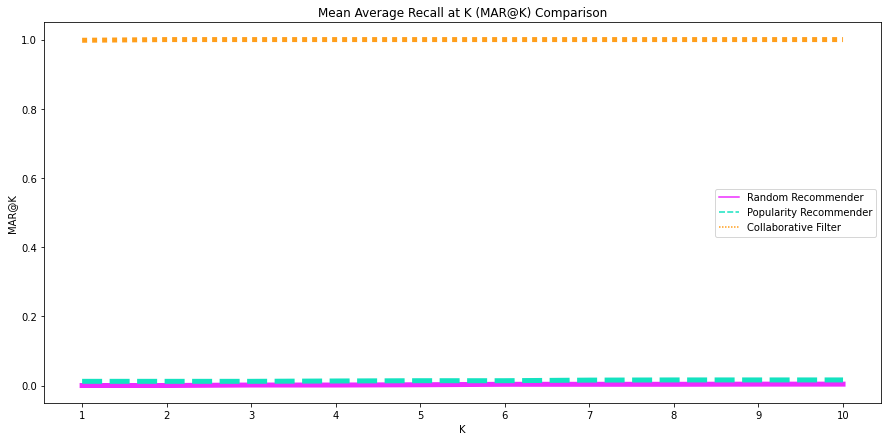

In [22]:
mark_scores = [random_mark, pop_mark, cf_mark]
index = range(1,11)
names = ['Random Recommender', 'Popularity Recommender', 'Collaborative Filter']

fig = plt.figure(figsize=(15, 7))
mark_plot(mark_scores, model_names=names, k_range=index)

# Saving predictions & model

In [23]:
dumping_path = join(_HERE, '..', '..', 'artifacts', 'k-nn.pkl')
dump(dumping_path, algo=algo, verbose=1)

The dump has been saved as file ../../artifacts/k-nn.pkl


# Inference stage

In [24]:
recommend(['Iron Man', 'Fast and Furious'], 10)

Computing the cosine similarity matrix...
Done computing similarity matrix.


['Iron Man (2008)',
 'Toy Story (1995)',
 'Toy Story 4 (2019)',
 'Persian Series #8 (2000)',
 'Persian Series #9 (2000)',
 'Persian Series #10 (2000)',
 'Persian Series #11 (2000)',
 'Persian Series #12 (2000)',
 'Persian Series #13 (2001)',
 'Persian Series #14 (2001)']

# Transform notebook to Python script

In [25]:
!jupyter nbconvert --to script k_nn.ipynb

[NbConvertApp] Converting notebook k_nn.ipynb to script
[NbConvertApp] Writing 4692 bytes to k_nn.py


In [26]:
collab_model(algo, ['Iron Man (1951)', 'Toy Story (1995)'], 3)

NameError: name 'cosine_similarity' is not defined